In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm

In [2]:
all_file = glob.glob('../../data/processed/apple_watch_format/1s/S*.csv')
df_all = pd.concat([pd.read_csv(file) for file in all_file], ignore_index=True, axis=0)
df_all.head()

,timestamp,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,HR,SDNN,label,subject
0,2025-04-30 00:09:46,58.76,5.12,-22.58,63.181194,1.129937,150.646154,7.8125,1,8
1,2025-04-30 00:10:23,42.84,-45.60,3.26,62.655244,0.424775,153.600000,0.0000,1,8
2,2025-04-30 00:13:13,36.70,-45.78,-22.60,62.898115,0.973212,140.800000,39.0625,1,8
3,2025-04-30 00:13:17,36.54,-44.30,-25.94,63.017899,0.494373,144.957265,7.8125,1,8
4,2025-04-30 00:13:26,40.18,-42.68,-18.30,62.998503,2.094901,130.506912,23.4375,1,8


In [3]:
df_all['focus_label'] = -1

In [4]:
df_all

,timestamp,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,HR,SDNN,label,subject,focus_label
0,2025-04-30 00:09:46,58.76,5.12,-22.58,63.181194,1.129937,150.646154,7.8125,1,8,-1
1,2025-04-30 00:10:23,42.84,-45.60,3.26,62.655244,0.424775,153.600000,0.0000,1,8,-1
2,2025-04-30 00:13:13,36.70,-45.78,-22.60,62.898115,0.973212,140.800000,39.0625,1,8,-1
3,2025-04-30 00:13:17,36.54,-44.30,-25.94,63.017899,0.494373,144.957265,7.8125,1,8,-1
4,2025-04-30 00:13:26,40.18,-42.68,-18.30,62.998503,2.094901,130.506912,23.4375,1,8,-1
...,...,...,...,...,...,...,...,...,...,...,...
360,2025-04-30 00:52:38,50.92,-25.00,-27.34,62.972409,0.309284,132.027972,54.6875,2,15,-1
361,2025-04-30 00:52:52,50.82,-25.00,-27.96,63.162668,0.311972,136.800000,54.6875,2,15,-1
362,2025-04-30 00:53:29,50.36,-24.04,-28.98,62.880944,0.408579,142.222222,0.0000,2,15,-1
363,2025-04-30 00:54:55,36.50,1.88,51.02,62.762340,0.297836,140.053050,23.4375,2,15,-1


In [5]:
def quest_load(subject_id):
    subject_path = f'../../data/raw/WESAD/S{subject_id}/S{subject_id}_quest.csv'

    with open(subject_path, 'r') as f:
        lines = f.readlines()

    order_line = [l for l in lines if l.startswith('# ORDER')][0]
    order = order_line.strip().split(';')[1:-1]
    order = [o.strip().lower() for o in order if o.strip() not in ['bread','fread','sread']]

    stai_dict = {}
    valence_dict = {}
    arousal_dict = {}

    stai_lines = [l for l in lines if l.startswith('# STAI')]
    dim_lines = [l for l in lines if l.startswith('# DIM')]

    stai_score = np.array([[int(i) for i in l.strip().split(';')[1:-1] if i.strip().isdigit()] for l in stai_lines])
    dim_score = np.array([[int(i) for i in l.strip().split(';')[1:-1] if i.strip().isdigit()] for l in dim_lines])

    # DIM score
    valence_score = dim_score[:, 0]
    arousal_score = dim_score[:, 1]

    min_len = min(len(order), len(valence_score))

    valence_score = valence_score[:min_len]
    arousal_score = arousal_score[:min_len]

    # STAI score
    for i, task in enumerate(order[:min_len]):
        if task.startswith('medi'):
            task_key = 'meditation'
        else:
            task_key = task

        positives = (stai_score[:, 0] + stai_score[:, 3] + stai_score[:, 5]) / 3
        negatives = (stai_score[:, 1] + stai_score[:, 2] + stai_score[:, 4]) / 3

        scored_stai = negatives[i] - positives[i]

        valence_dict[task_key] = valence_score[i]
        arousal_dict[task_key] = arousal_score[i]
        stai_dict[task_key] = scored_stai

    return{
        'valence': valence_dict,
        'arousal': arousal_dict,
        'stai': stai_dict
    }

In [6]:
quest_dict = {}
for s in df_all['subject'].unique():
    quest_dict[s] = quest_load(s)

In [7]:
label_to_task = {
    1: 'base',
    2: 'tsst',
    3: 'fun',
    4: 'meditation'
}

In [8]:
def refined_label(lbl, dim_arousal, dim_valence, stai_score):
    if lbl in [1, 4]:
        if (dim_arousal <= 3) and (dim_valence >= 5):
            return 1
        else:
            return 0
        
    elif lbl == 2:
        if stai_score <= 0:
            if dim_arousal >= 5:
                return 1
            else:
                return 0
        else:
            return 0
        
    else:
        return 0

In [9]:
for i, row in tqdm(df_all.iterrows(), total=len(df_all)):
    subj = int(row['subject'])
    lbl = int(row['label'])

    if lbl not in label_to_task:
        continue

    task_name = label_to_task[lbl]
    quest = quest_dict[subj]

    # ดึงคะแนนที่ต้องใช้
    dim_arousal = quest['arousal'][task_name]
    dim_valence = quest['valence'][task_name]
    stai_score = quest['stai'][task_name] if lbl == 2 else None

    # คำนวณ label
    focus = refined_label(lbl, dim_arousal, dim_valence, stai_score)

    # บันทึกลง dataframe
    df_all.at[i, 'focus_label'] = focus

100%|██████████| 365/365 [00:00<00:00, 43838.30it/s]


In [10]:
df_all

,timestamp,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,HR,SDNN,label,subject,focus_label
0,2025-04-30 00:09:46,58.76,5.12,-22.58,63.181194,1.129937,150.646154,7.8125,1,8,1
1,2025-04-30 00:10:23,42.84,-45.60,3.26,62.655244,0.424775,153.600000,0.0000,1,8,1
2,2025-04-30 00:13:13,36.70,-45.78,-22.60,62.898115,0.973212,140.800000,39.0625,1,8,1
3,2025-04-30 00:13:17,36.54,-44.30,-25.94,63.017899,0.494373,144.957265,7.8125,1,8,1
4,2025-04-30 00:13:26,40.18,-42.68,-18.30,62.998503,2.094901,130.506912,23.4375,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...
360,2025-04-30 00:52:38,50.92,-25.00,-27.34,62.972409,0.309284,132.027972,54.6875,2,15,0
361,2025-04-30 00:52:52,50.82,-25.00,-27.96,63.162668,0.311972,136.800000,54.6875,2,15,0
362,2025-04-30 00:53:29,50.36,-24.04,-28.98,62.880944,0.408579,142.222222,0.0000,2,15,0
363,2025-04-30 00:54:55,36.50,1.88,51.02,62.762340,0.297836,140.053050,23.4375,2,15,0


In [11]:
df_all.value_counts('focus_label')

focus_label
0    272
1     93
Name: count, dtype: int64

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
palette = {0: "#708090", 1: "#6A0DAD"}

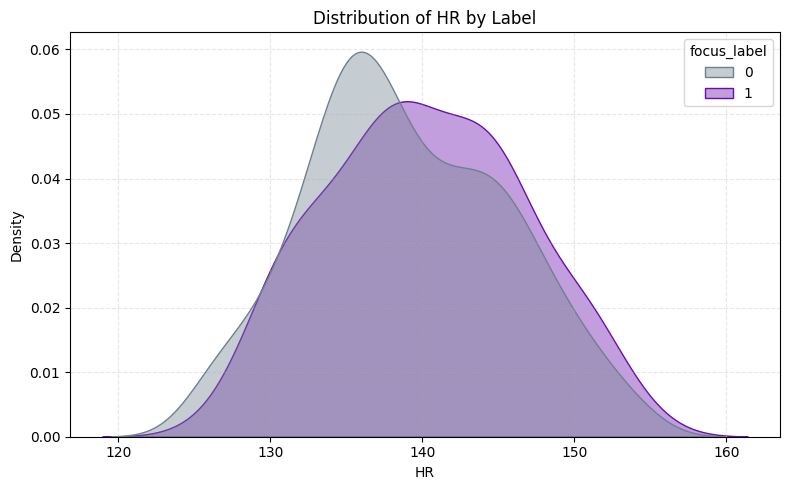

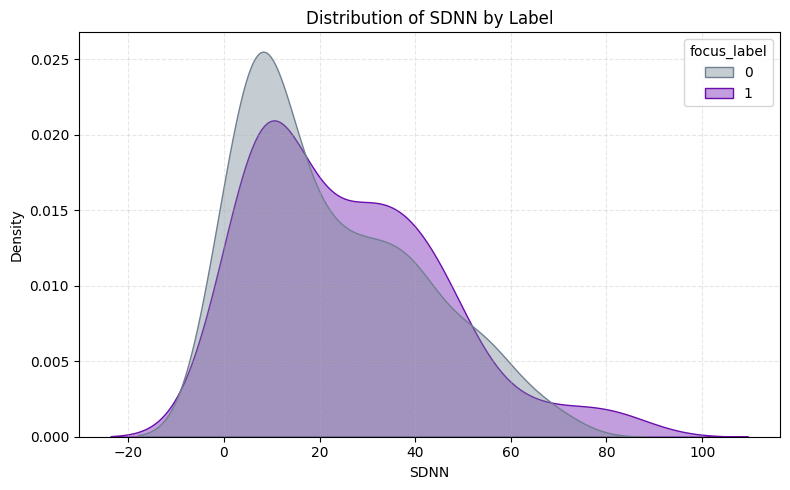

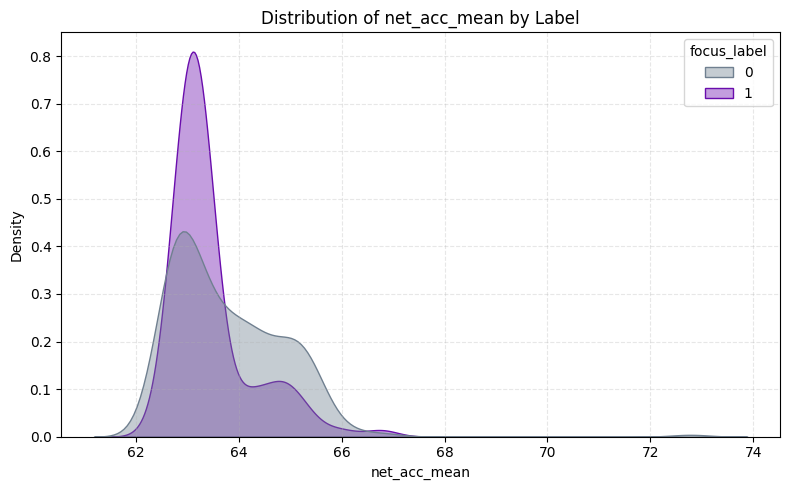

In [14]:
for feature in ['HR','SDNN', 'net_acc_mean']:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df_all, x=feature, hue='focus_label',
                common_norm=False, palette=palette, fill=True, alpha=0.4)
    plt.title(f'Distribution of {feature} by Label')
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [15]:
df_all

,timestamp,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,HR,SDNN,label,subject,focus_label
0,2025-04-30 00:09:46,58.76,5.12,-22.58,63.181194,1.129937,150.646154,7.8125,1,8,1
1,2025-04-30 00:10:23,42.84,-45.60,3.26,62.655244,0.424775,153.600000,0.0000,1,8,1
2,2025-04-30 00:13:13,36.70,-45.78,-22.60,62.898115,0.973212,140.800000,39.0625,1,8,1
3,2025-04-30 00:13:17,36.54,-44.30,-25.94,63.017899,0.494373,144.957265,7.8125,1,8,1
4,2025-04-30 00:13:26,40.18,-42.68,-18.30,62.998503,2.094901,130.506912,23.4375,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...
360,2025-04-30 00:52:38,50.92,-25.00,-27.34,62.972409,0.309284,132.027972,54.6875,2,15,0
361,2025-04-30 00:52:52,50.82,-25.00,-27.96,63.162668,0.311972,136.800000,54.6875,2,15,0
362,2025-04-30 00:53:29,50.36,-24.04,-28.98,62.880944,0.408579,142.222222,0.0000,2,15,0
363,2025-04-30 00:54:55,36.50,1.88,51.02,62.762340,0.297836,140.053050,23.4375,2,15,0


In [16]:
df_all.to_csv('../../data/processed/apple_watch_format/1s/data_with_focus.csv')